# <span style="color:deepskyblue">3.평균 이동 </span>    
---

## <span style="color:lightpink">평균 이동의 개요</span> 

평균 이동은 k-평균과 유사하게 중심을 데이터가 모여 있는 밀도가 가장 높은 군집의 중심으로 지속적으로 움직이면서 군집화를 수행

평균 이동 군집화는 데이터의 분포도를 이용하여 군집 중심점을 찾음  
군집 중심점은 데이터가 가장 집중적으로 모여있는 PDF의 피크인 점을 의미  
주어진 모델의 PDF를 찾기 위해 KDE(커널 함수를 통해 어떤 변수의 pdf를 추정)를 이용  

$KDE=\frac{1}{n}\sum_{i=1}^{n}K_{h}(x-x_i)=\frac{1}{nh}\sum_{i=1}^{n}K(\frac{x-x_i}{h})$

h는 대역폭을 의미하고 KDE 형태를 부드러운 형태로 평활화하는데 적용  
h를 어떻게 적용하냐에 PDF의 성능을 크게 좌우할 수 있음

h=1이면 좁고 뾰족 -> 변동성이 큰 방식으로 추정 -> 과적합    
h=10이면 과도하게 평활화 -> 단순하게 추정 -> 과소적합

In [3]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, 
                  cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


bandwidthrk는 KDE의 h와 동일

In [4]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


3개로 잘 군집화 됨

In [6]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


bandwidthrk를 최적화 값으로 설정하는 것이 중요

In [7]:
import pandas as pd


clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

best_bandwidth = estimate_bandwidth(X)

meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))    

cluster labels 유형: [0 1 2]


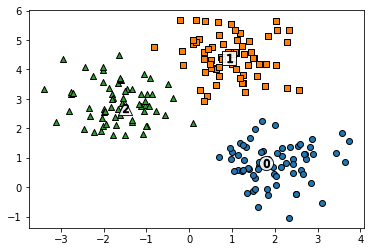

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', 
                marker=markers[label] )
    
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                edgecolor='k', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)
    
plt.show()

In [9]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       1                  67
1       0                  67
2       2                  66
Name: meanshift_label, dtype: int64


데이터 세트의 형태를 특정 형태로 가정한다든가 특정 분포도 기반의 모델로 가정하지 않기 때문에 평균 이동은 좀 더 유연한 군집화가 가능  
이상치의 영향력도 크지 않고, 미리 군집의 개수를 정할 필요도 없음  
bandwidth의 크기가 군집화에 영향을 미침  
이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추정하는데 뛰어난 역할을 함

# <span style="color:deepskyblue">4.GMM </span>    
---

## <span style="color:lightpink">GMM소개</span> 